In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/DIST/

/content/drive/My Drive/DIST


In [3]:
!sh download_dataset.sh

--2020-01-09 20:53:45--  http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar [following]
--2020-01-09 20:53:45--  https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/octet-stream]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  15.4MB/s    in 2m 43s  

2020-01-09 20:56:29 (11.7 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]

VOCdevkit/
VOCdevkit/VOC2012/
VOCdevkit/VOC2012/Annotations/
VOCdevkit/VOC2012/Annotations/2007_000027.xml
VOCdevkit/VOC2012/Annotations/2007_000032.xml
VOCdevkit

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

from data_loader import Pascal_Data
import matplotlib.pyplot as plt
import torch.nn.functional as F


from ResBack.utils import batch_pix_accuracy, batch_intersection_union
from ResBack import resnet
from torch.nn.functional import upsample

from ResBack.model_store import get_model_file

In [0]:
from ResBack.datasets import pascal_voc

In [0]:
root = './data/Pascal_VOC'

In [8]:
input_transform = T.Compose([
            T.ToTensor(),
            T.Normalize([.485, .456, .406], [.229, .224, .225])])
        # dataset
data_kwargs = {'transform': input_transform, 'base_size': 520,
                       'crop_size': 480}
trainset = pascal_voc.VOCSegmentation(root=root, split='train', mode='train', **data_kwargs)
testset = pascal_voc.VOCSegmentation(root=root, split='val', mode ='val', **data_kwargs)

69it [00:00, 681.94it/s]

BaseDataset: base_size 520, crop_size 480


2913it [00:04, 660.60it/s]
1449it [00:02, 654.77it/s]


In [0]:
kwargs = {'num_workers': 4}
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                           drop_last=True, shuffle=True, **kwargs)
valloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         drop_last=False, shuffle=False, **kwargs)
nclass = trainset.num_class

In [0]:
kwargs = {}
val_loader = torch.utils.data.DataLoader(
        Pascal_Data(root, image_set='val', backbone='resnet'),
        batch_size=1, shuffle=False, **kwargs)

In [10]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [11]:
for data, target in trainloader: break
print(data.shape)
print(target.shape)

torch.Size([8, 3, 480, 480])
torch.Size([8, 480, 480])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


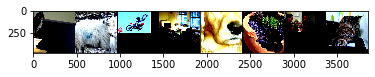

In [12]:
import torchvision
x=data.data.cpu()
img=torchvision.utils.make_grid(x)
img = img / 2 + 0.2    # unnormalize
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [0]:
def resnet50(pretrained=False, root='~/.encoding/models', **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = resnet.ResNet(resnet.Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(torch.load(
            get_model_file('resnet50', root=root)), strict=False)
    return model

In [0]:
class BaseNet(nn.Module):
    def __init__(self, nclass, backbone, aux, se_loss, jpu=True, dilated=False, norm_layer=None,
                 base_size=520, crop_size=480, mean=[.485, .456, .406],
                 std=[.229, .224, .225], root='~/.encoding/models', **kwargs):
        super(BaseNet, self).__init__()
        self.nclass = nclass
        self.aux = aux
        self.se_loss = se_loss
        self.mean = mean
        self.std = std
        self.base_size = base_size
        self.crop_size = crop_size
        # copying modules from pretrained models
        if backbone == 'resnet50':
            self.pretrained = resnet50(pretrained=True, dilated=dilated,
                                              norm_layer=norm_layer, root=root)
        elif backbone == 'resnet101':
            self.pretrained = resnet.resnet101(pretrained=True, dilated=dilated,
                                               norm_layer=norm_layer, root=root)
        elif backbone == 'resnet152':
            self.pretrained = resnet.resnet152(pretrained=True, dilated=dilated,
                                               norm_layer=norm_layer, root=root)
        else:
            raise RuntimeError('unknown backbone: {}'.format(backbone))
        # bilinear upsample options
        self._up_kwargs = {'mode': 'bilinear', 'align_corners': True}
        self.backbone = backbone
        
    def base_forward(self, x):
        x = self.pretrained.conv1(x)
        x = self.pretrained.bn1(x)
        x = self.pretrained.relu(x)
        x = self.pretrained.maxpool(x)
        c1 = self.pretrained.layer1(x)
        c2 = self.pretrained.layer2(c1)
        c3 = self.pretrained.layer3(c2)
        c4 = self.pretrained.layer4(c3)

        return c1, c2, c3, c4

    def evaluate(self, x, target=None):
        pred = self.forward(x)
        if isinstance(pred, (tuple, list)):
            pred = pred[0]
        if target is None:
            return pred
        correct, labeled = batch_pix_accuracy(pred.data, target.data)
        inter, union = batch_intersection_union(pred.data, target.data, self.nclass)
        return correct, labeled, inter, union

In [0]:
class FCN(BaseNet):
    r"""Fully Convolutional Networks for Semantic Segmentation
    Parameters
    ----------
    nclass : int
        Number of categories for the training dataset.
    backbone : string
        Pre-trained dilated backbone network type (default:'resnet50'; 'resnet50',
        'resnet101' or 'resnet152').
    norm_layer : object
        Normalization layer used in backbone network (default: :class:`mxnet.gluon.nn.BatchNorm`;
    Reference:
        Long, Jonathan, Evan Shelhamer, and Trevor Darrell. "Fully convolutional networks
        for semantic segmentation." *CVPR*, 2015
    Examples
    --------
    >>> model = FCN(nclass=21, backbone='resnet50')
    >>> print(model)
    """
    def __init__(self, nclass, backbone, aux=True, se_loss=False, norm_layer=nn.BatchNorm2d, **kwargs):
        super(FCN, self).__init__(nclass, backbone, aux, se_loss, norm_layer=norm_layer, **kwargs)
        self.head = FCNHead(2048, nclass, norm_layer)
        if aux:
            self.auxlayer = FCNHead(1024, nclass, norm_layer)

    def forward(self, x):
        imsize = x.size()[2:]
        _, _, c3, c4 = self.base_forward(x)

        x = self.head(c4)
        x = upsample(x, imsize, **self._up_kwargs)
        outputs = [x]
        if self.aux:
            auxout = self.auxlayer(c3)
            auxout = upsample(auxout, imsize, **self._up_kwargs)
            outputs.append(auxout)
        return tuple(outputs)

        
class FCNHead(nn.Module):
    def __init__(self, in_channels, out_channels, norm_layer):
        super(FCNHead, self).__init__()
        inter_channels = in_channels // 4
        self.conv5 = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False),
                                   norm_layer(inter_channels),
                                   nn.ReLU(),
                                   nn.Dropout2d(0.1, False),
                                   nn.Conv2d(inter_channels, out_channels, 1))

    def forward(self, x):
        return self.conv5(x)



In [16]:
teacher = torch.hub.load('pytorch/vision:v0.4.2', 'fcn_resnet101', pretrained=True)
teacher.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.4.2.zip" to /root/.cache/torch/hub/v0.4.2.zip
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:00<00:00, 258MB/s]
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [00:01<00:00, 113MB/s]


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [17]:
student = FCN(nclass=21, backbone='resnet50',pretrained=False)

Model file /root/.encoding/models/resnet50-ebb6acbb.pth is not found. Downloading.


57462KB [00:04, 12208.92KB/s]                           


## Sanity check before training

In [0]:
iter_loader=iter(trainloader)
data, target = next(iter_loader)
    
data = data.to('cuda')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


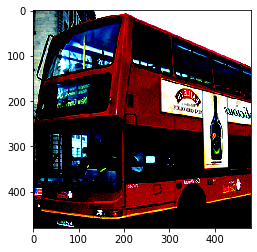

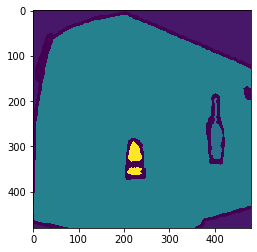

In [32]:

data_show = data[0].cpu().clone()
label_show = target[0]

data_show = np.transpose(data_show.numpy(), (1, 2, 0))

plt.imshow(data_show)
plt.show()

plt.imshow(label_show)
plt.show()

In [0]:
teacher.to('cuda')
with torch.no_grad():
  outT=teacher(data)['out']

In [21]:
student.to('cuda')
with torch.no_grad():
  test=student(data)[0]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [22]:
print('input: ', data.shape)
print('output: ', outT.data.shape)

input:  torch.Size([8, 3, 480, 480])
output:  torch.Size([8, 21, 480, 480])


In [23]:
print('input: ', data.shape)
print('output: ', test.data.shape)

input:  torch.Size([8, 3, 480, 480])
output:  torch.Size([8, 21, 480, 480])


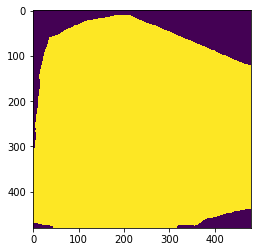

In [33]:
from PIL import Image
o_p=outT[0].argmax(0)
r = Image.fromarray(o_p.byte().cpu().numpy())
plt.imshow(r)

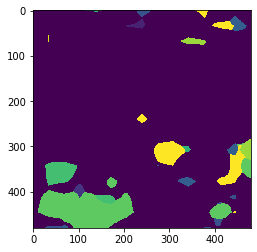

In [34]:
ss=test[0]
o_s=ss.argmax(0)
rs = Image.fromarray(o_s.byte().cpu().numpy())
plt.imshow(rs)

## Training

In [0]:
tstOptim=torch.optim.SGD([
            {'params': student.pretrained.parameters(), 'lr': 2.0e-4},
            {'params': student.head.parameters(), 'lr': 2.0e-3},
            {'params': student.auxlayer.parameters(), 'lr': 2.0e-3},
                        ],
            lr=2.0e-4,
            momentum=0.9,
            weight_decay=0.0005
        )

In [0]:
def kd_loss(input, target,label):
    # input: (n, c, h, w), target: (n, c, h, w)
    n, c, h, w = input.size()
    T=20

    # log_p_i: (n, c, h, w)
    log_p_i = F.log_softmax(input/T, dim=1)
    # log_p_i: (n*h*w, c)
    log_p_i = log_p_i.view(n*h*w,c)

    # log_p_t: (n, c, h, w)
    log_p_t = F.softmax(target/T, dim=1)
    # log_p_t: (n*h*w, c)
    log_p_t = log_p_t.view(n*h*w,c)


    criterion = nn.KLDivLoss()
    loss=nn.KLDivLoss()(log_p_i,log_p_t)* (0.9 * T * T)+ \
              cross_entropy2d(input, label) * (1. - 0.9)
    return loss

In [0]:
def cross_entropy2d(input, target, weight=None, size_average=True):
    # input: (n, c, h, w), target: (n, h, w)
    n, c, h, w = input.size()
    # log_p: (n, c, h, w)
    log_p = F.log_softmax(input, dim=1)
    # log_p: (n*h*w, c)
    log_p = log_p.transpose(1, 2).transpose(2, 3).contiguous()
    log_p = log_p[target.view(n, h, w, 1).repeat(1, 1, 1, c) >= 0]
    log_p = log_p.view(-1, c)
    # target: (n*h*w,)
    mask = target >= 0
    target = target[mask]
    loss = F.nll_loss(log_p, target, weight=weight, size_average=False)
    if size_average:
        loss /= mask.data.sum()
    return loss

In [0]:
def train(model,teacher, optimizer, epochs=1):
    """
    Train a model on Pascal VOC using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train. Student.
    - teacher: A teacher network freezed and in eval mode.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    teacher = teacher.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(trainloader):
            model.train()  # put model to training mode
            teacher.eval() # put teacher to eval mode
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)  # move to device, e.g. GPU

            scores = model(x)[0]
            with torch.no_grad():
              lecture= teacher(x)['out']
            
            loss = kd_loss(scores, lecture,y)
           
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % 100 == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                print()

In [0]:
train(student,teacher,tstOptim,20)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1946: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Iteration 0, loss = 0.5329



## Accuracy calculation by mIoU metric

In [0]:
def check_accuracy_t(model):
    
    num_correct = 0
    n_class = len(val_loader.dataset.class_names)
    num_samples = 0
    val_loss = 0
    bestIu=0
    label_trues, label_preds = [], []
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(val_loader):
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)

            score = model(x)['out']

            imgs = x.data.cpu()
            lbl_pred = score.data.max(1)[1].cpu().numpy()[:, :, :]
            lbl_true = y.data.cpu()
            for img, lt, lp in zip(imgs, lbl_true, lbl_pred):
                img, lt = val_loader.dataset.untransform(img, lt)
                label_trues.append(lt)
                label_preds.append(lp)
            
        
            metrics = label_accuracy_score(label_trues, label_preds, n_class)
            mean_iu = metrics[2]
            if mean_iu>bestIu:
              bestIu=mean_iu

            if t % 100 == 0:
                print('Iteration %d, IU = %.4f' % (t, mean_iu))
                print()

In [0]:
from utils import label_accuracy_score
def check_accuracy(model):
    
    num_correct = 0
    n_class = len(val_loader.dataset.class_names)
    num_samples = 0
    val_loss = 0
    bestIu=0
    label_trues, label_preds = [], []
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(val_loader):
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)

            score = model(x)[0]

            imgs = x.data.cpu()
            lbl_pred = score.data.max(1)[1].cpu().numpy()[:, :, :]
            lbl_true = y.data.cpu()
            for img, lt, lp in zip(imgs, lbl_true, lbl_pred):
                img, lt = val_loader.dataset.untransform(img, lt)
                label_trues.append(lt)
                label_preds.append(lp)
            
            metrics = label_accuracy_score(label_trues, label_preds, n_class)
            mean_iu = metrics[2]
            if mean_iu>bestIu:
              bestIu=mean_iu

            if t % 100 == 0:
                print('Iteration %d, IU = %.4f' % (t, mean_iu))
                print()

In [25]:
check_accuracy(student)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/content/drive/My Drive/DIST/utils.py:48: RuntimeWarning: invalid value encountered in true_divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)
/content/drive/My Drive/DIST/utils.py:50: RuntimeWarning: invalid value encountered in true_divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))


Iteration 0, IU = 0.8592

Iteration 100, IU = 0.6189

Iteration 200, IU = 0.6154

Iteration 300, IU = 0.6161

Iteration 400, IU = 0.6147



KeyboardInterrupt: ignored

In [0]:
check_accuracy_t(teacher)

/content/drive/My Drive/DIST/utils.py:48: RuntimeWarning: invalid value encountered in true_divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)
/content/drive/My Drive/DIST/utils.py:50: RuntimeWarning: invalid value encountered in true_divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))


Iteration 0, IU = 0.9274

Iteration 100, IU = 0.7690

Iteration 200, IU = 0.7587

Iteration 300, IU = 0.7589

Iteration 400, IU = 0.7527

Iteration 500, IU = 0.7628

Iteration 600, IU = 0.7676

Iteration 700, IU = 0.7690

Iteration 800, IU = 0.7688

Iteration 900, IU = 0.7667

Iteration 1000, IU = 0.7624



# Visualization of Outputs from Student and Teacher models after training

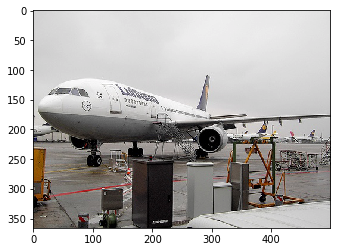

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [62]:
for t, (x, y) in enumerate(val_loader):break

teacher.eval()
student.eval()

data_show, label_show = val_loader.dataset.untransform(x[0].cpu().clone(), y[0].cpu().clone())

plt.imshow(data_show)
plt.show()

x = x.to(device=device)  # move to device, e.g. GPU
y = y.to(device=device)

with torch.no_grad(): 
  lecture= teacher(x)['out']
  guest=student(x)[0]

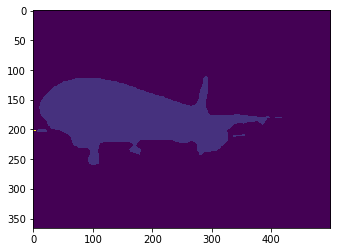

In [63]:
from PIL import Image
o_p=lecture[0].argmax(0)
r = Image.fromarray(o_p.byte().cpu().numpy())
plt.imshow(r)

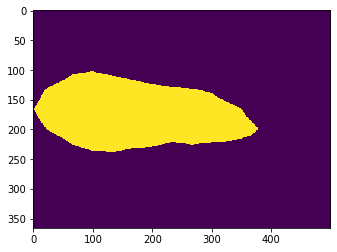

In [64]:
ss=guest[0]
o_s=ss.argmax(0)
rs = Image.fromarray(o_s.byte().cpu().numpy())
plt.imshow(rs)